In [42]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import pathlib as pl
#from uncertainties.unumpy import nominal_values as noms
#from uncertainties.unumpy import std_devs as stds


**5.1** Spectrometer Measurement

Taking data with the spectrometer to use as background reference

In [43]:
# Import the roomlight reference data as a pandas DataFrame
ref_roomlight_on = pd.read_csv("gc_roomlight.txt", sep="\t")
ref_roomlight_off = pd.read_csv("gc_roomlight_off.txt", sep="\t")

print(ref_roomlight_on,ref_roomlight_off)

      #lambda/nm     DC     C1
0        208.295  638.2  641.0
1        208.670  561.0  559.4
2        209.045  528.2  523.2
3        209.419  517.4  517.2
4        209.794  611.4  613.2
...          ...    ...    ...
2043    1129.520  593.2  588.8
2044    1129.890  583.6  587.2
2045    1130.260  583.6  588.8
2046    1130.640  575.4  592.0
2047    1131.010  587.0  584.6

[2048 rows x 3 columns]       #lambda/nm     DC     C1
0        208.295  633.0  633.2
1        208.670  551.8  550.2
2        209.045  517.4  517.8
3        209.419  506.0  509.8
4        209.794  600.2  606.4
...          ...    ...    ...
2043    1129.520  543.2  541.6
2044    1129.890  545.2  546.8
2045    1130.260  531.8  535.4
2046    1130.640  536.0  532.2
2047    1131.010  545.6  543.4

[2048 rows x 3 columns]


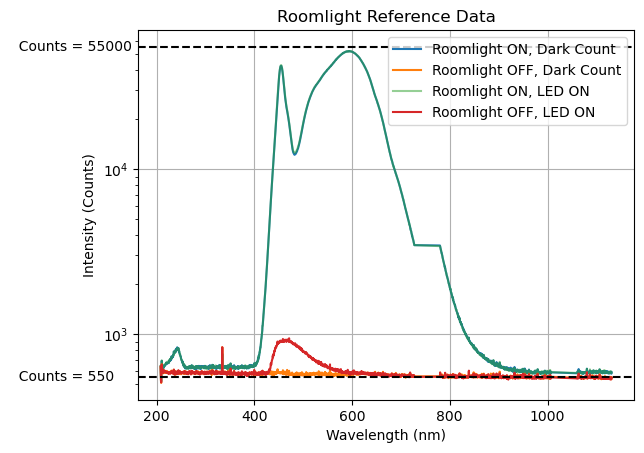

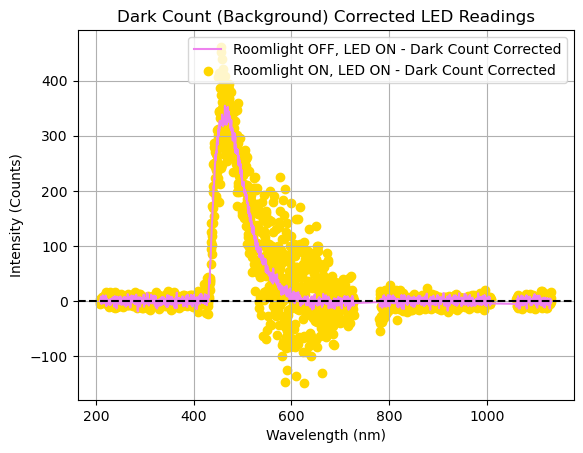

In [44]:
# Plot the roomlight data with lights on and off
plt.plot(ref_roomlight_on['#lambda/nm'], ref_roomlight_on['DC'], label='Roomlight ON, Dark Count')
plt.plot(ref_roomlight_off['#lambda/nm'], ref_roomlight_off['DC'], label='Roomlight OFF, Dark Count')
plt.plot(ref_roomlight_on['#lambda/nm'], ref_roomlight_on['C1'], label='Roomlight ON, LED ON',alpha=0.5)
plt.plot(ref_roomlight_off['#lambda/nm'], ref_roomlight_off['C1'], label='Roomlight OFF, LED ON')
plt.axhline(y=550, color='black', linestyle='--')
plt.axhline(y=55000, color='black', linestyle='--')
plt.text(-100, 550, f'  Counts = 550', va='center', ha='left', color='black')
plt.text(-100, 55000, f'  Counts = 55000', va='center', ha='left', color='black')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity (Counts)')
plt.title('Roomlight Reference Data')
plt.legend()
plt.grid()
plt.yscale('log')
plt.show()

# LED count - Dark Count for roomlight off
ref_roomlight_corr = pd.DataFrame({
    '#lambda/nm': ref_roomlight_off['#lambda/nm'].astype(float),
    'Count_off': (ref_roomlight_off['C1'] - ref_roomlight_off['DC']).astype(float),
    'Count_on': (ref_roomlight_on['C1'] - ref_roomlight_on['DC']).astype(float)
})

# Plot the corrected roomlight off data
plt.plot(ref_roomlight_corr['#lambda/nm'], ref_roomlight_corr['Count_off'], label='Roomlight OFF, LED ON - Dark Count Corrected', color='violet')
plt.scatter(ref_roomlight_corr['#lambda/nm'], ref_roomlight_corr['Count_on'], label='Roomlight ON, LED ON - Dark Count Corrected', color='gold')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity (Counts)')
plt.title('Dark Count (Background) Corrected LED Readings')
plt.legend()
plt.grid()
plt.show()

**5.2** Radial Symmetry Measurement

Taking data with varying angles in the spectrometer to test the symmetry of the system

In [45]:
# "gc_radial" file path
gc_radial_folder = pl.Path("gc_radial")

# Import Radial Symmetry Dataframe

df_list = []
for file in gc_radial_folder.glob("*.txt"):
    df = pd.read_csv(file, sep="\t", header=None)
    # Add 3rd column: filename without extension
    df['Measurement'] = file.stem
    df.columns = ['#lambda/nm', 'C1', 'Measurement Specifications']
    df_list.append(df[1:])

radial_df = pd.concat(df_list, ignore_index=True)

print(radial_df.head())

  #lambda/nm     C1    Measurement Specifications
0    208.295  544.6  DarkCounts_h=10deg_v=34.8deg
1     208.67  487.4  DarkCounts_h=10deg_v=34.8deg
2    209.045  453.2  DarkCounts_h=10deg_v=34.8deg
3    209.419  450.4  DarkCounts_h=10deg_v=34.8deg
4    209.794  603.8  DarkCounts_h=10deg_v=34.8deg


In [46]:
# Sum the counts for each measurement specification across all wavelengths
radial_df['C1'] = radial_df['C1'].astype(float)
summed_radial_df = radial_df.groupby('Measurement Specifications', as_index=False)[['#lambda/nm', 'C1']].sum(numeric_only=True)

# Drop the '#lambda/nm' column if it STILL exists because it is a fucking ghost
if '#lambda/nm' in summed_radial_df.columns:
    summed_radial_df = summed_radial_df.drop(columns=['#lambda/nm'])

# Split the first column into three columns
split_cols = summed_radial_df['Measurement Specifications'].str.split('_', expand=True)

# Extract measurement type, h angle, and v angle
summed_radial_df['Measurement type'] = split_cols[0]
summed_radial_df['h angle'] = split_cols[1].str.extract(r'h=([-\d.]+)deg').astype(float)
summed_radial_df['v angle'] = split_cols[2].str.extract(r'v=([-\d.]+)deg').astype(float)

# Drop the Measurement specifications column
summed_radial_df = summed_radial_df.drop(columns=['Measurement Specifications'])

# Move the 'C1' column to the end and rename it to 'Counts'
summed_radial_df['Counts'] = summed_radial_df['C1']
summed_radial_df = summed_radial_df.drop(columns=['C1'])

# Subtract DarkCounts from Attenuation for matching h angle and v angle
Attenuation_df = summed_radial_df[summed_radial_df['Measurement type'] == 'Attenuation']
DarkCount_df = summed_radial_df[summed_radial_df['Measurement type'] == 'DarkCounts']

# Merge Attenuation_df and DarkCount_df on 'h angle' and 'v angle'
subtracted_radial_df = pd.merge(
    Attenuation_df,
    DarkCount_df,
    on=['h angle', 'v angle'],
    suffixes=('_atten', '_dark')
)

# Subtract the counts
subtracted_radial_df['Counts_subtracted'] = subtracted_radial_df['Counts_atten'] - subtracted_radial_df['Counts_dark']

print(subtracted_radial_df.head())


  Measurement type_atten  h angle  v angle  Counts_atten  \
0            Attenuation    -10.0     -2.6     1214415.8   
1            Attenuation    -10.0     -6.0     1213050.6   
2            Attenuation    -10.0      0.8     1214077.0   
3            Attenuation    -10.0     11.0     1208326.8   
4            Attenuation    -10.0     14.4     1207325.6   

  Measurement type_dark  Counts_dark  Counts_subtracted  
0            DarkCounts    1158286.6            56129.2  
1            DarkCounts    1157506.0            55544.6  
2            DarkCounts    1158206.0            55871.0  
3            DarkCounts    1159245.0            49081.8  
4            DarkCounts    1159708.4            47617.2  


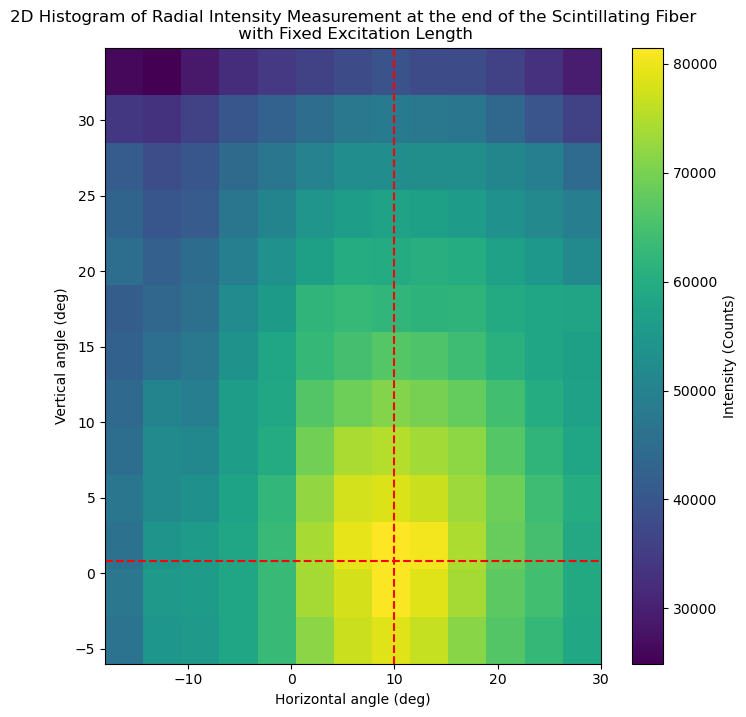

In [47]:
# 2D Histogram of the subtracted radial data

# Pivot the dataframe to create a 2D grid for plotting
hist2d_sub = subtracted_radial_df.pivot(index='v angle', columns='h angle', values='Counts_subtracted')

plt.figure(figsize=(8, 8))
plt.imshow(hist2d_sub.values, 
           extent=[hist2d_sub.columns.min(), hist2d_sub.columns.max(), 
                   hist2d_sub.index.min(), hist2d_sub.index.max()],
           origin='lower', 
           aspect='auto', 
           interpolation='nearest')
plt.colorbar(label='Intensity (Counts)')

# Find the indices of the maximum value in the histogram
max_idx = np.unravel_index(np.nanargmax(hist2d_sub.values), hist2d_sub.shape)
max_v = hist2d_sub.index[max_idx[0]]
max_h = hist2d_sub.columns[max_idx[1]]
plt.axvline(x=max_h, color='red', linestyle='--', label=f'x={max_h:.1f}')
plt.axhline(y=max_v, color='red', linestyle='--', label=f'y={max_v:.1f}')

plt.xlabel('Horizontal angle (deg)')
plt.ylabel('Vertical angle (deg)')
plt.title('2D Histogram of Radial Intensity Measurement at the end of the Scintillating Fiber\n with Fixed Excitation Length')

plt.show()


**5.3** Intensity Measurement

Measure of Intensity with the change of angles (h and v) and fiber excitation distance from the measurement point (x value)

In [48]:
# "gc_intensity" file path
gc_intensity_folder = pl.Path("gc_Intensity")

# Import Intensity Dataframe

df2_list = []
for file in gc_intensity_folder.glob("*.txt"):
    df = pd.read_csv(file, sep="\t", header=None)
    # Add 3rd column: filename without extension
    df['Measurement'] = file.stem
    df.columns = ['#lambda/nm', 'C1', 'Measurement Specifications']
    df2_list.append(df[1:])

intensity_df = pd.concat(df2_list, ignore_index=True)

print(intensity_df.head())

  #lambda/nm     C1         Measurement Specifications
0    208.295  512.4  Attenuation_h=0deg_v=0deg_x=450mm
1     208.67  469.2  Attenuation_h=0deg_v=0deg_x=450mm
2    209.045  426.4  Attenuation_h=0deg_v=0deg_x=450mm
3    209.419    435  Attenuation_h=0deg_v=0deg_x=450mm
4    209.794    613  Attenuation_h=0deg_v=0deg_x=450mm


In [49]:
# Sum the counts for each measurement specification across all wavelengths
intensity_df['C1'] = intensity_df['C1'].astype(float)  
summed_intensity_df = intensity_df.groupby('Measurement Specifications', as_index=False)[['#lambda/nm', 'C1']].sum(numeric_only=True)

# Drop the '#lambda/nm' column if it STILL exists because it is a fucking ghost
if '#lambda/nm' in summed_intensity_df.columns:
    summed_intensity_df = summed_intensity_df.drop(columns=['#lambda/nm'])

# Split the first column into three columns
split_cols = summed_intensity_df['Measurement Specifications'].str.split('_', expand=True)

# Extract measurement type, h angle, and v angle
summed_intensity_df['Measurement type'] = split_cols[0]
summed_intensity_df['h angle'] = split_cols[1].str.extract(r'h=([-\d.]+)deg').astype(float)
summed_intensity_df['v angle'] = split_cols[2].str.extract(r'v=([-\d.]+)deg').astype(float)
summed_intensity_df['x length'] = split_cols[3].str.extract(r'x=([-\d.]+)mm').astype(float)

# Drop the Measurement specifications column
summed_intensity_df = summed_intensity_df.drop(columns=['Measurement Specifications'])

# Move the 'C1' column to the end and rename it to 'Counts'
summed_intensity_df['Counts'] = summed_intensity_df['C1']
summed_intensity_df = summed_intensity_df.drop(columns=['C1'])

# Subtract Darkcounts from each Attenuation measurement
Attenuation_intensity_df = summed_intensity_df[summed_intensity_df['Measurement type'] == 'Attenuation']
Attenuation_intensity_df = Attenuation_intensity_df.drop(columns=['Measurement type'])
DarkCount_intensity_df = summed_intensity_df[summed_intensity_df['Measurement type'] == 'DarkCounts']
DarkCount_intensity_df = DarkCount_intensity_df.drop(columns=['Measurement type'])

# Merge Attenuation_df and DarkCount_df on 'h angle', 'v angle' and 'x length'
subtracted_intensity_df = pd.merge(
    Attenuation_intensity_df,
    DarkCount_intensity_df,
    on=['h angle', 'v angle'],
    suffixes=('_atten', '_dark')
)

# Subtract the counts
subtracted_intensity_df['Counts_subtracted'] = subtracted_intensity_df['Counts_atten'] - subtracted_intensity_df['Counts_dark']

print(subtracted_intensity_df.head())


   h angle  v angle  x length_atten  Counts_atten  x length_dark  Counts_dark  \
0      0.0      0.0             0.0     1291794.4            NaN    1224125.4   
1      0.0      0.0          1050.0     1259649.0            NaN    1224125.4   
2      0.0      0.0          1125.0     1259661.4            NaN    1224125.4   
3      0.0      0.0          1200.0     1259298.6            NaN    1224125.4   
4      0.0      0.0          1275.0     1258059.2            NaN    1224125.4   

   Counts_subtracted  
0            67669.0  
1            35523.6  
2            35536.0  
3            35173.2  
4            33933.8  


/tmp/ipykernel_5787/1211079102.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  fit1_params, _ = curve_fit(exp_decay, fit1['x length_atten'], fit1['Counts_subtracted'],p0=(67669.0, 0.002))


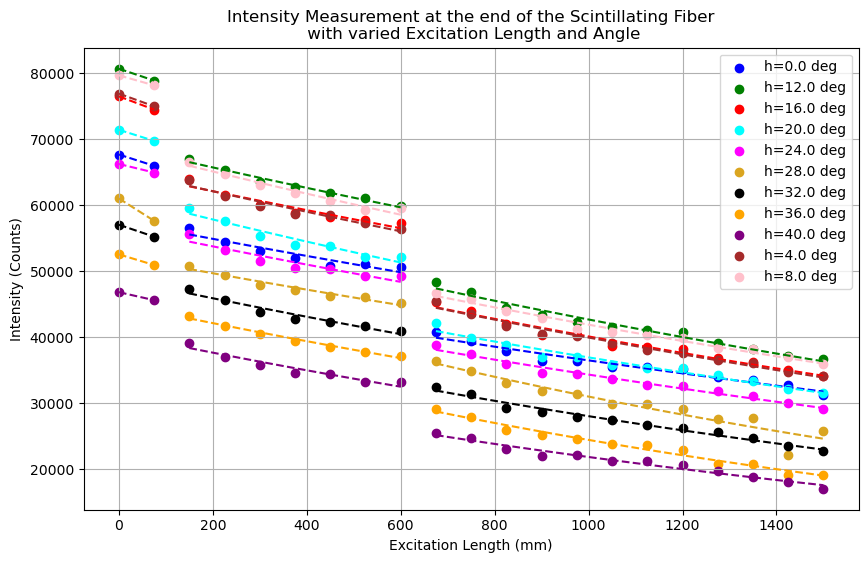

In [50]:
# CORRECTION COMMENT: FIT FOR 3 UNBROKEN INTERVALS

# Fit func exp(a0 +)
def exp_decay(x, a, b):
    return a * np.exp(-b * x)

# Plot the subtracted intensity data for various angles

colors = [
    'blue',
    'green',
    'red',
    'cyan',
    'magenta',
    'goldenrod',
    'black',
    'orange',
    'purple',
    'brown',
    'pink'
]

sex=0

plt.figure(figsize=(10, 6))
for h_angle in subtracted_intensity_df['h angle'].unique():
    # First Fit
    fit1 = subtracted_intensity_df[(subtracted_intensity_df['h angle'] == h_angle) & (subtracted_intensity_df['x length_atten'] < 100)]
    fit1_params, _ = curve_fit(exp_decay, fit1['x length_atten'], fit1['Counts_subtracted'],p0=(67669.0, 0.002))

    x_fit1 = np.linspace(fit1['x length_atten'].min(), fit1['x length_atten'].max(), 2)
    y_fit1 = exp_decay(x_fit1, *fit1_params)
    plt.plot(x_fit1, y_fit1, linestyle='--',color=colors[sex])

    # Second Fit
    fit2 = subtracted_intensity_df[(subtracted_intensity_df['h angle'] == h_angle) & (subtracted_intensity_df['x length_atten'] > 100) & (subtracted_intensity_df['x length_atten'] < 650)]  
    fit2_params, _ = curve_fit(exp_decay, fit2['x length_atten'], fit2['Counts_subtracted'],p0=(66483.0, 0.002))

    x_fit2 = np.linspace(fit2['x length_atten'].min(), fit2['x length_atten'].max(), 55)
    y_fit2 = exp_decay(x_fit2, *fit2_params)
    plt.plot(x_fit2, y_fit2, linestyle='--',color=colors[sex])

    # Third Fit
    fit3 = subtracted_intensity_df[(subtracted_intensity_df['h angle'] == h_angle) & (subtracted_intensity_df['x length_atten'] > 650)]
    fit3_params, _ = curve_fit(exp_decay, fit3['x length_atten'], fit3['Counts_subtracted'],p0=(40804.0, 0.002))

    x_fit3 = np.linspace(fit3['x length_atten'].min(), fit3['x length_atten'].max(), 85)
    y_fit3 = exp_decay(x_fit3, *fit3_params)
    plt.plot(x_fit3, y_fit3, linestyle='--',color=colors[sex])


    subset = subtracted_intensity_df[subtracted_intensity_df['h angle'] == h_angle]
    plt.scatter(subset['x length_atten'], subset['Counts_subtracted'], label=f'h={h_angle} deg',color=colors[sex])
    sex += 1
plt.xlabel('Excitation Length (mm)')
plt.ylabel('Intensity (Counts)')
plt.title('Intensity Measurement at the end of the Scintillating Fiber\n with varied Excitation Length and Angle')
plt.legend()
plt.grid()
plt.show()

**Simulation data (.pkl) analysis**

In [51]:
# Import the pickle file
pklfile = "SimData.pkl"

# Open the file in binary read mode and load its contents
with open(pklfile, 'rb') as f:
    simdata = pickle.load(f)

# Print the loaded data
print(type(simdata))
print(simdata)

/tmp/ipykernel_5787/2051878613.py:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  simdata = pickle.load(f)


<class 'pandas.core.frame.DataFrame'>
       # y_exit    z_exit      x_start   y_start   z_start  px_start  \
0     -0.026978 -0.061619  2400.019897 -0.051878  0.096635  0.948434   
1     -0.055254  0.050902  2400.000732  0.085666  0.015889  0.977825   
2      0.049212  0.065583  2399.990967  0.006511 -0.025208  0.917937   
3     -0.018177 -0.106197  2400.062012 -0.043234 -0.098842  0.885576   
4      0.050591  0.043467  2400.000977 -0.004035 -0.069628  0.971248   
...         ...       ...          ...       ...       ...       ...   
12190 -0.046607  0.029443   199.925171 -0.036812 -0.031668  0.951252   
12191  0.106568  0.010214   200.010742 -0.091458 -0.051768  0.856789   
12192  0.080448 -0.062861   200.003174  0.107887 -0.000503  0.994160   
12193 -0.006622  0.073915   200.003418 -0.054177 -0.022690  0.925610   
12194 -0.131603 -0.247919   199.913208 -0.050254 -0.156630  0.877131   

       py_start  pz_start  reflCoCl  reflClCl          wl  gpsPosX  \
0      0.162628 -0.272077  

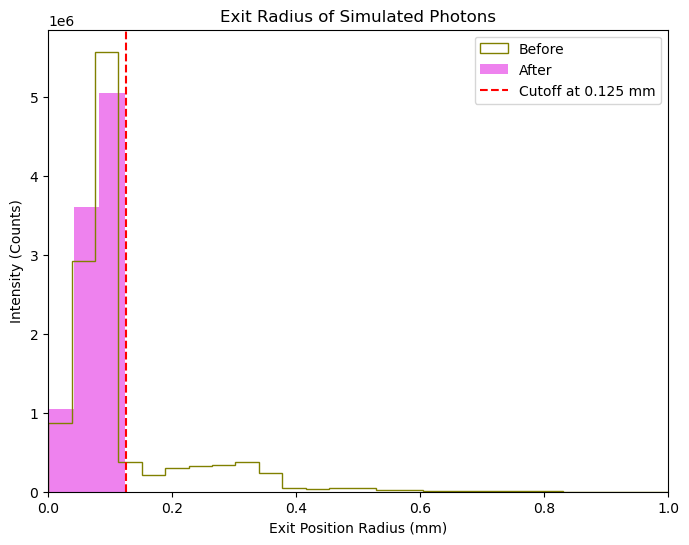

       # y_exit    z_exit      x_start   y_start   z_start  px_start  \
0     -0.026978 -0.061619  2400.019897 -0.051878  0.096635  0.948434   
1     -0.055254  0.050902  2400.000732  0.085666  0.015889  0.977825   
2      0.049212  0.065583  2399.990967  0.006511 -0.025208  0.917937   
3     -0.018177 -0.106197  2400.062012 -0.043234 -0.098842  0.885576   
4      0.050591  0.043467  2400.000977 -0.004035 -0.069628  0.971248   
...         ...       ...          ...       ...       ...       ...   
12189 -0.093757  0.036602   200.005493 -0.086116 -0.020527  0.825783   
12190 -0.046607  0.029443   199.925171 -0.036812 -0.031668  0.951252   
12191  0.106568  0.010214   200.010742 -0.091458 -0.051768  0.856789   
12192  0.080448 -0.062861   200.003174  0.107887 -0.000503  0.994160   
12193 -0.006622  0.073915   200.003418 -0.054177 -0.022690  0.925610   

       py_start  pz_start  reflCoCl  reflClCl          wl  gpsPosX  \
0      0.162628 -0.272077    3649.0       0.0  472.743103   2400.

In [52]:
# Remove unphysical values from the simulation data where exit point is more than 0.125mm
simdata['r_exit'] = np.sqrt(np.square(simdata['# y_exit']) + np.square(simdata['z_exit']))

# Removing
simdata_p = simdata[simdata['r_exit'] < 0.125]

# Plot the cutoff for the exit point
plt.figure(figsize=(8, 6))
plt.hist(simdata['r_exit'], bins=100,histtype='step', color='olive', label='Before')
plt.hist(simdata_p['r_exit'], bins=3, color='violet', label='After')
plt.axvline(x=0.125, color='red', linestyle='--', label='Cutoff at 0.125 mm')
plt.xlim(0, 1)
plt.xlabel('Exit Position Radius (mm)')
plt.ylabel('Intensity (Counts)')
plt.title('Exit Radius of Simulated Photons')
plt.legend()
plt.show()

# Removing
simdata_p = simdata[simdata['r_exit'] < 0.125]
print(simdata_p)

/tmp/ipykernel_5787/2159182464.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simdata_p['reflangle'] = np.degrees(np.arccos(simdata_p['px_start'] / np.sqrt(simdata_p['px_start']**2 + simdata_p['py_start']**2 + simdata_p['pz_start']**2)))


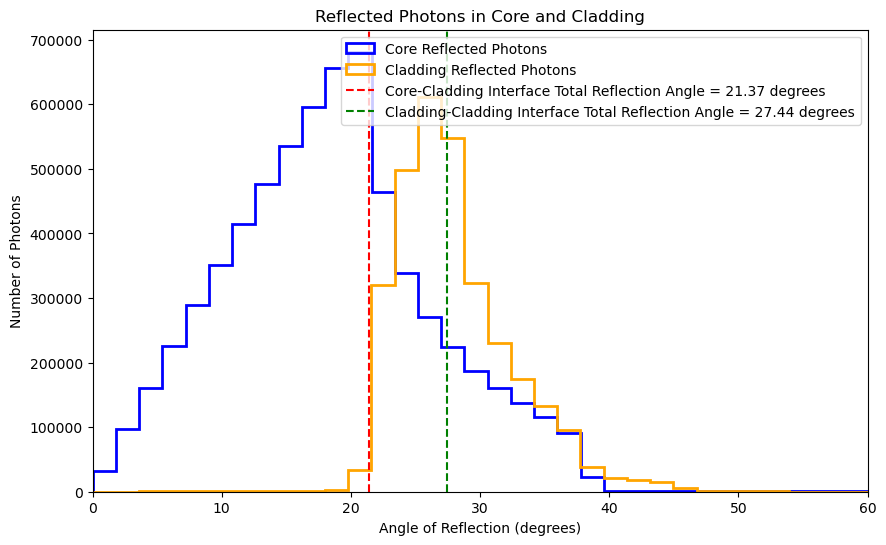

In [53]:
# Separately plot core and cladding reflected photons
simdata_p['reflangle'] = np.degrees(np.arccos(simdata_p['px_start'] / np.sqrt(simdata_p['px_start']**2 + simdata_p['py_start']**2 + simdata_p['pz_start']**2)))

# Plot the angle of reflection for core and cladding reflected photons
plt.figure(figsize=(10, 6))
plt.hist(simdata_p['reflangle'][simdata_p['reflCoCl'] != 0], bins=100, histtype='step', color='blue', linewidth=2, label='Core Reflected Photons')
plt.hist(simdata_p['reflangle'][simdata_p['reflClCl'] != 0], bins=100, histtype='step', color='orange', linewidth=2, label='Cladding Reflected Photons')

# The total reflection angles
plt.axvline(x=21.37, color='red', linestyle='--', label='Core-Cladding Interface Total Reflection Angle = 21.37 degrees')
plt.axvline(x=27.44, color='green', linestyle='--', label='Cladding-Cladding Interface Total Reflection Angle = 27.44 degrees')

plt.xlabel('Angle of Reflection (degrees)')
plt.ylabel('Number of Photons')
plt.xlim(0, 60)
plt.legend()
plt.title('Reflected Photons in Core and Cladding')
plt.show()

/tmp/ipykernel_5787/2854351097.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simdata_p['r_min'] = np.abs(simdata_p['z_start']*simdata_p['py_start'] - simdata_p['pz_start']*simdata_p['y_start']) / np.sqrt(simdata_p['pz_start']**2 + simdata_p['py_start']**2)


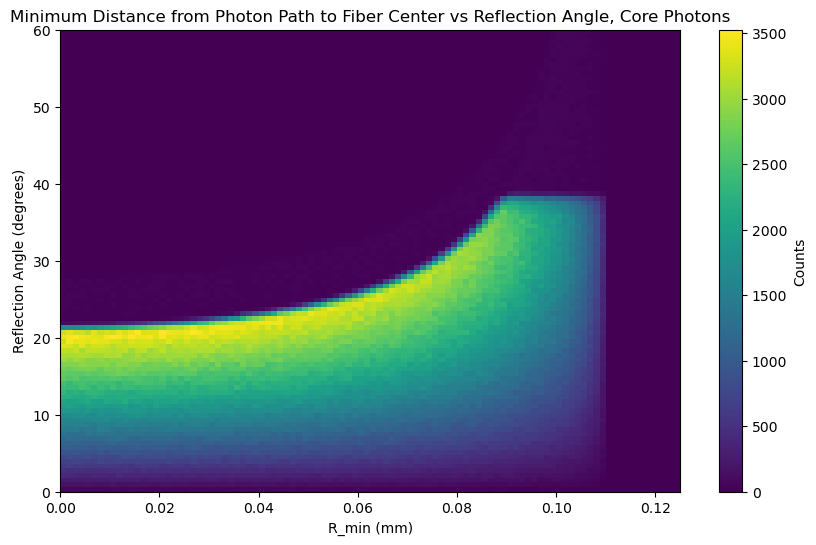

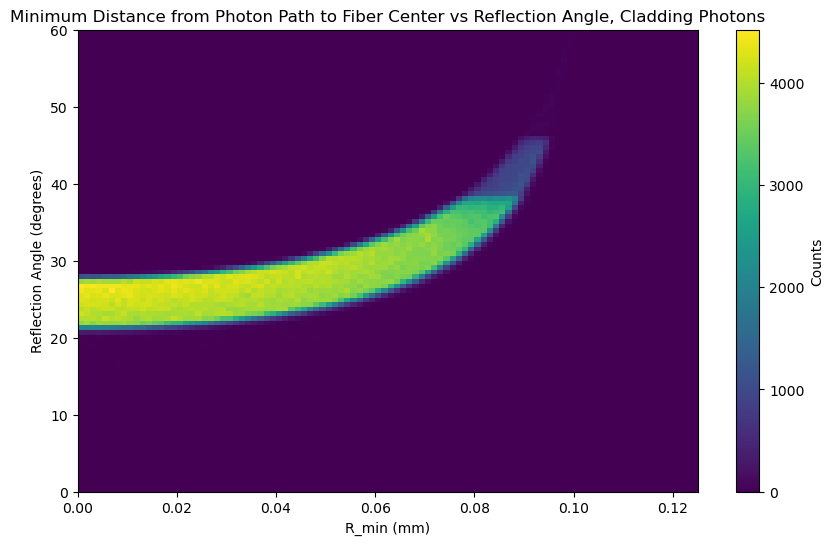

In [54]:
# r_min, minimum distance between the path of the photon and the center of the fiber
simdata_p['r_min'] = np.abs(simdata_p['z_start']*simdata_p['py_start'] - simdata_p['pz_start']*simdata_p['y_start']) / np.sqrt(simdata_p['pz_start']**2 + simdata_p['py_start']**2)

# 2D histogram of R_min vs reflection angle
# Core Photons
plt.figure(figsize=(10, 6))
plt.hist2d(simdata_p['r_min'][simdata_p['reflCoCl'] != 0], simdata_p['reflangle'][simdata_p['reflCoCl'] != 0], bins=[100, 100], range=[[0, 0.125], [0, 60]], cmap='viridis')
plt.ylabel('Reflection Angle (degrees)')
plt.xlabel('R_min (mm)')
plt.title('Minimum Distance from Photon Path to Fiber Center vs Reflection Angle, Core Photons')
plt.colorbar(label='Counts')
plt.ylim(0, 60)
plt.xlim(0, 0.125)
plt.grid(False)
plt.show()

# Cladding Photons
plt.figure(figsize=(10, 6))
plt.hist2d(simdata_p['r_min'][simdata_p['reflClCl'] != 0], simdata_p['reflangle'][simdata_p['reflClCl'] != 0], bins=[100, 100], range=[[0, 0.125], [0, 60]], cmap='viridis')
plt.ylabel('Reflection Angle (degrees)')
plt.xlabel('R_min (mm)')
plt.title('Minimum Distance from Photon Path to Fiber Center vs Reflection Angle, Cladding Photons')
plt.colorbar(label='Counts')
plt.ylim(0, 60)
plt.xlim(0, 0.125)
plt.grid(False)
plt.show()

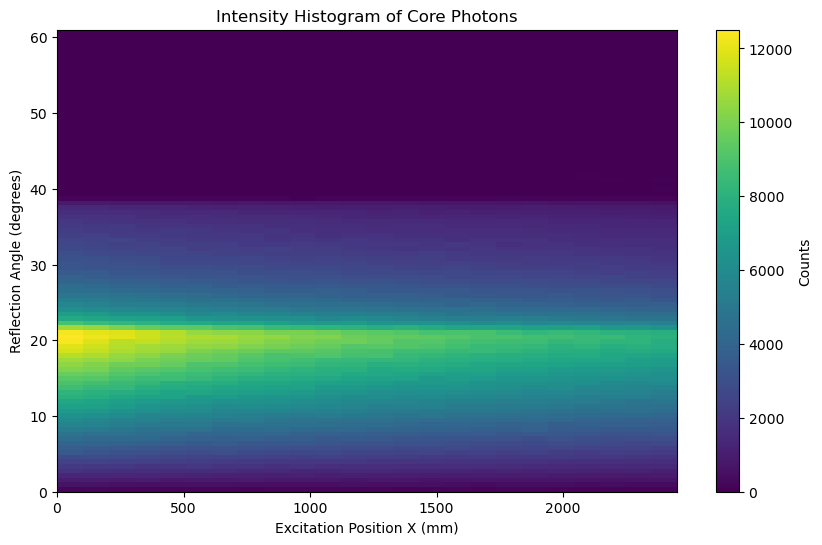

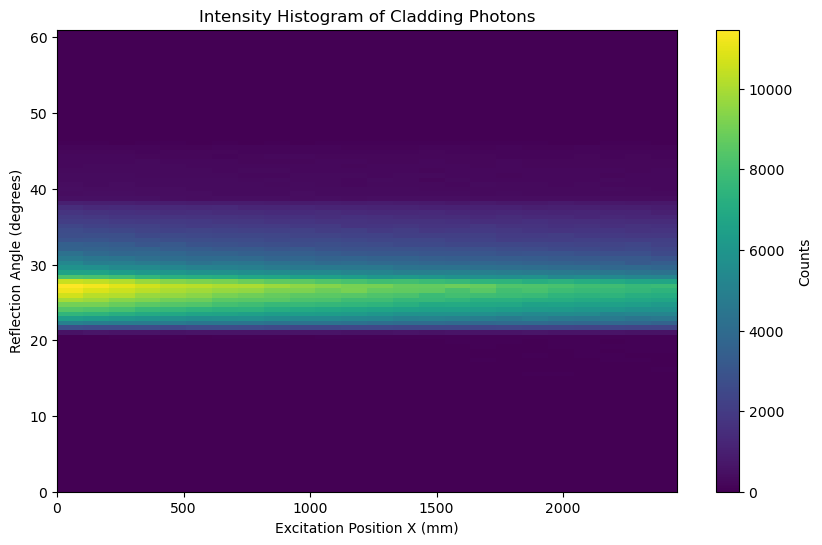

In [55]:
# Intensity Histogram

# Shouldve done this earlier...
simdata_core = simdata_p[simdata_p['reflCoCl'] != 0]
simdata_cladding = simdata_p[simdata_p['reflClCl'] != 0]

plt.figure(figsize=(10, 6))
plt.hist2d(simdata_core['gpsPosX'], simdata_core['reflangle'], bins=[24,100], range=[[0, 2450], [0, 61]], cmap='viridis', label='Core Photons')
plt.ylabel('Reflection Angle (degrees)')
plt.xlabel('Excitation Position X (mm)')
plt.title('Intensity Histogram of Core Photons')
plt.colorbar(label='Counts')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist2d(simdata_cladding['gpsPosX'], simdata_cladding['reflangle'], bins=[24,100], range=[[0, 2450], [0, 61]], cmap='viridis', label='Cladding Photons')
plt.ylabel('Reflection Angle (degrees)')
plt.xlabel('Excitation Position X (mm)')
plt.title('Intensity Histogram of Cladding Photons')
plt.colorbar(label='Counts')
plt.show()  


/tmp/ipykernel_5787/114710504.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  fit_params = pd.concat([fit_params, pd.DataFrame([{"angle": angle, "a_eff param": popt[1],"other param": popt[0], "err": np.sqrt(np.diag(pcov))[1]}])], ignore_index=True)


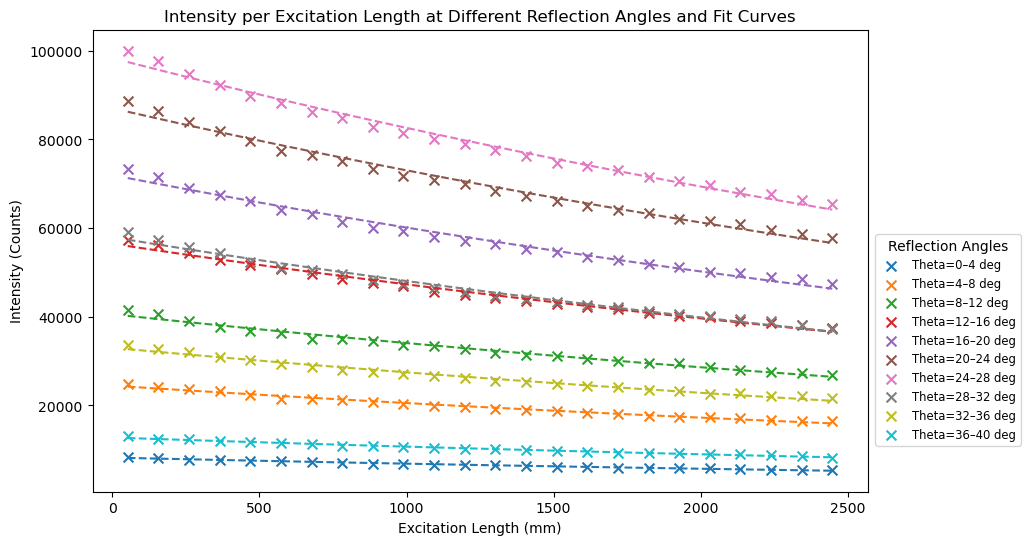

In [60]:
# Intensity per excitation length at different reflection angles

# Exit angle calculation
#simdata_p['ang_exit'] = np.arcsin(np.sqrt(1 - ((simdata_p['r_min']**2)/(0.125**2))) * np.sin((simdata_p['reflangle'])))*180/np.pi

# Fit func exp(a0 +)
def exp_decay(x, a, b):
    return a * np.exp(-b * x)

fit_params = pd.DataFrame(columns=["angle", "a_eff param", "other param", "err"])

plt.figure(figsize=(10, 6))
#rad_min = pd.DataFrame(columns=["r_min"])
for angle in range(0, 40, 4):
    subset = simdata_p[(simdata_p['reflangle'] >= angle) & (simdata_p['reflangle'] < angle + 4)]
    #rad_min = pd.concat([subset['r_min'], rad_min], ignore_index=True)
    y, x = np.histogram(subset['gpsPosX'], bins=24, range=[0, 2500])
    x_centers = (x[:-1] + x[1:]) / 2
    plt.scatter(x_centers, y, label=f'Theta={angle}–{angle+4} deg', marker='x', s=50)

    popt, pcov = curve_fit(exp_decay, x_centers, y, p0=[np.max(y), 2*(10**-4)])
    plt.plot(x_centers, exp_decay(x_centers, *popt), '--')
    fit_params = pd.concat([fit_params, pd.DataFrame([{"angle": angle, "a_eff param": popt[1],"other param": popt[0], "err": np.sqrt(np.diag(pcov))[1]}])], ignore_index=True)

plt.xlabel('Excitation Length (mm)')
plt.ylabel('Intensity (Counts)')
plt.title('Intensity per Excitation Length at Different Reflection Angles and Fit Curves')
plt.legend(loc=(1.01, 0.1), fontsize='small', title='Reflection Angles')
plt.show()


/tmp/ipykernel_5787/2576305200.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  measurement_params = pd.concat([measurement_params, pd.DataFrame([{"angle": h_angle, "a_eff param": popt2[1],"other param": popt2[0], "err": np.sqrt(np.diag(pcov2))[1]}])], ignore_index=True)


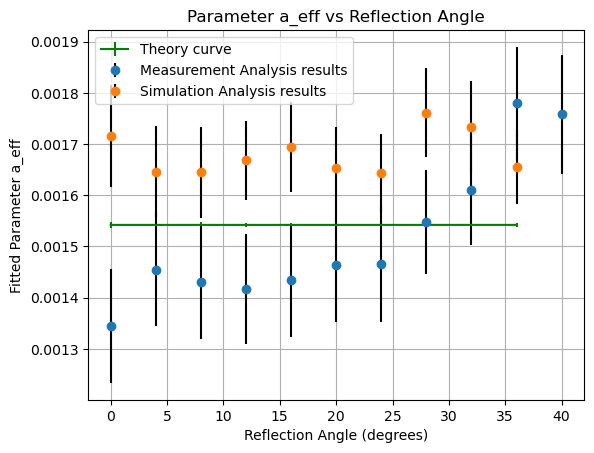

In [68]:
# Theory curve vs. fit curve

a_avg = np.mean(fit_params['a_eff param'].values)
other_avg = np.mean(fit_params['other param'].values)
angles = fit_params['angle'].astype(float)

# Fit function for the theory curve
def f(x, a, b):
    return a/np.cos(b*x)

x_theo = np.linspace(0, 45, 1000)
plt.errorbar(angles, f(angles, other_avg * np.pi * (10**-8), a_avg), yerr=fit_params["err"], label='Theory curve', c='green')

# Measurement analysis points
measurement_params = pd.DataFrame(columns=["angle", "a_eff param", "other param", "err"])

for h_angle in subtracted_intensity_df['h angle'].unique():
    subset = subtracted_intensity_df[subtracted_intensity_df['h angle'] == h_angle]
    popt2, pcov2 = curve_fit(exp_decay, subset['x length_atten'], subset['Counts_subtracted'], p0=[np.max(subset['Counts_subtracted']), 2*(10**-4)])
    measurement_params = pd.concat([measurement_params, pd.DataFrame([{"angle": h_angle, "a_eff param": popt2[1],"other param": popt2[0], "err": np.sqrt(np.diag(pcov2))[1]}])], ignore_index=True)
plt.errorbar(
    measurement_params["angle"],
    measurement_params["a_eff param"]*2.5,
    yerr=measurement_params["err"]*3.5,
    fmt='o',
    linestyle='',
    ecolor='black',
    label='Measurement Analysis results'
)

# Simulation analysis points
plt.errorbar(
    fit_params['angle'].astype(float),
    fit_params['a_eff param']*3*np.pi,
    yerr=fit_params["err"]*6*np.pi,
    marker='o',
    linestyle='',
    ecolor='black',
    label='Simulation Analysis results'
)

plt.xlabel('Reflection Angle (degrees)')
plt.ylabel('Fitted Parameter a_eff')
plt.title('Parameter a_eff vs Reflection Angle')
plt.grid()
plt.legend()
plt.show()
